In [1]:
import os
import gym
import pickle
import matplotlib.pyplot as plt
import numpy as np
import ppaquette_gym_doom
from collections import deque

In [2]:
# Create a classic Doom environment with Gym
env = gym.make('ppaquette/DoomDefendCenter-v0')

INFO:gym.envs.registration:Making new env: ppaquette/DoomDefendCenter-v0
[2017-05-07 22:50:12,900] Making new env: ppaquette/DoomDefendCenter-v0


In [ ]:
# Computer vision utils
%matplotlib inline
from PIL import Image
from scipy.stats import threshold
from scipy.signal import medfilt
from scipy.misc import toimage
import time
import pylab as pl
from IPython import display

# Draw function refreshes every 5000 frames
frame_count = 0
refresh_rate = 5000

def encode_screen(observation):
  # Crop & downsampling & grayscale
  cropped = observation[150:230:3, ::2 , :]
  r = cropped[:,:,0]
  return projection(pixelate(r))

def show(mat):
  global frame_count
  global refresh_rate
  if frame_count % refresh_rate == 0:
    plt.imshow(toimage(mat))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    #toimage(mat).show()
  frame_count += 1
  frame_count = frame_count % 1000

def plot_inline(data):
    global frame_count
    global refresh_rate
    if frame_count % refresh_rate == 0:
      plt.clf()
      plt.plot(data)
      display.clear_output(wait=True)
      display.display(plt.gcf())
      time.sleep(1)
    frame_count += 1
    frame_count = frame_count % 3000

"""
Coarse pixelate
"""
def pixelate(observation):
  global frame_count
  # Threshold
  m = threshold(observation, threshmin=100, threshmax=None, newval=0)
  # Remove noise
  m = medfilt(m, 3)
  return m

def projection(pixels):
  # Horizontal projection
  _,w = pixels.shape
  proj = np.zeros(w)
  for x in range(w):
    proj[x] = np.sum(pixels[:,x])
    
  proj -= np.min(proj)
  proj = np.gradient(proj)[1:-1] # Remove edges
  proj = proj > 100
  proj.astype(int)

  # Reduce
  pj = []
  count = np.count_nonzero
  start = 0
  stride = 20
  while len(proj[start:start+stride])>0:
    # pj.append(count(proj[start:start+stride]) > 3)
    pj.append(np.mean(proj[start:start+stride]))
    start += stride+1
  pj = np.around(pj, decimals=1)
  #plot_inline(pj)
  return str(pj)

In [3]:
class TDAgent():
    def __init__(self,\
               learn_rate=0.05,\
               observation_encoder=lambda x: x,\
               verbose=True):
        self.alpha = 1.0 # Degree of temporal difference
        self.policy = dict() # Vπ: state => action => R 
        self.state_transitions = dict() # state => new_state => action to take
        self.total_reward = 0
        self.learn_rate = learn_rate
        self.observation_encoder = observation_encoder
        self.action_mapping = {} # Map [action str] => [action object]
        self.history = deque() # List of (state, action, reward), first is newest
    
    def reset(self):
        self.history.clear()
        self.total_reward = 0
    
    def learn_aggregate(self, observation, observation_, action, reward):
        # Encode [observation] => [state]
        state  = self.observation_encoder(observation)
        state_ = self.observation_encoder(observation_)

        # Record state transition inferred by action
        if state not in self.state_transitions:
            self.state_transitions[state] = {state_ : str(action)}
        self.state_transitions[state][state_] = str(action)
        
        self.history.appendleft((state, str(action), reward))
        self.action_mapping[str(action)] = action
        self.learn_V(state, str(action), reward, state_)
        self.total_reward += reward
        
    """
    Find maximum possible reward we would get
    from the best action attempted on [state]
    """
    def find_best_action(self, state):
        # From [state], identify the best [next_state]
        # which is valued the highest return
        if state not in self.state_transitions:
            return (-1, 0)
        best_next_action = -1
        best_next_reward = 0
        for state_ in self.state_transitions[state]:
            a = self.state_transitions[state][state_]
            v = self.V(state, a)
            if v >= best_next_reward:
                best_next_action = a
                best_next_reward = v
        
        return (best_next_action, best_next_reward)
            
    
    def decode_action(self, action):
        if action not in self.action_mapping:
          return None
        else: 
          return self.action_mapping[action]
    
    """
    Query the value policy V(state):π
    """
    def V(self, state, action):
        if state not in self.policy:
            self.policy[state] = {action: 0}
            return 0
        if action not in self.policy[state]:
            self.policy[state][action] = 0
            return 0
        return self.policy[state][action]

    """
    Update the value policy π
    """
    def learn_V(self, state, action, reward, next_state):
        old_V = self.V(state, action)
        new_V = self.V(next_state, action)
        
        self.policy[state][action] = old_V + \
            self.learn_rate * (reward + self.alpha * new_V - old_V)
    
    @staticmethod
    def load(path, default):
        if os.path.isfile(path):
          with open(path,'rb') as f:
            return pickle.load(f) 
        else:
          print('MODEL NOT FOUND, initialising a brand new one.')
          return default

    @staticmethod
    def save(path,agent):
        with open(path,'wb+') as f:
          return pickle.dump(agent, f)

In [5]:
# Play (TRAINING)
model_name = 'TDAgent.pkl'
score_records = [] # Scores of each round
turn_records = [] # Number of turns lasting each round
num_episodes = 500
all_actions = set(range(3)) # Attack / Right / Left

bot = TDAgent.load(model_name,\
                  TDAgent(learn_rate=0.8, \
                         observation_encoder=encode_screen))

for i in range(num_episodes):
  if num_episodes<25 or i % 25 == 0:
    print('Ep#{} started...'.format(i))
  observation = env.reset()
  num_turns = 0
  action_space = set()
  while True:
    env.render()
    
    # Try to find best action, otherwise, random
    state = bot.observation_encoder(observation)
    action, _ = bot.find_best_action(state)
    if action == -1:
      action = env.action_space.sample()
    else:
      # print('... Best action reward : ', bot.V(state, action)) # TAODEBUG:
      action = bot.decode_action(action)

    observation_, reward, done, info = env.step(action)
    bot.learn_aggregate(observation, observation_, action, reward)
    observation = np.copy(observation_)
    num_turns  += 1
    if done:
      score_records.append(bot.total_reward)
      turn_records.append(num_turns)
      if num_episodes<25 or i % 25 == 0:
        print('...[DONE] Max score so far : {}'.format(max(score_records)))
      # Save the agent
      TDAgent.save(model_name, bot)
      bot.reset()
      break
        
print('All {} episodes of training are DONE.'.format(num_episodes))

MODEL NOT FOUND, initialising a brand new one.
Ep#0 started...
...[DONE] Total reward : 0.0
Ep#25 started...
...[DONE] Total reward : 1.0
Ep#50 started...
...[DONE] Total reward : 0.0
Ep#75 started...
...[DONE] Total reward : 2.0
Ep#100 started...
...[DONE] Total reward : -1.0
Ep#125 started...
...[DONE] Total reward : 1.0
Ep#150 started...
...[DONE] Total reward : 1.0
Ep#175 started...
...[DONE] Total reward : 1.0
Ep#200 started...
...[DONE] Total reward : -1.0
Ep#225 started...
...[DONE] Total reward : 4.0
Ep#250 started...
...[DONE] Total reward : 4.0
Ep#275 started...
...[DONE] Total reward : 4.0
Ep#300 started...
...[DONE] Total reward : 1.0
Ep#325 started...
...[DONE] Total reward : 4.0
Ep#350 started...
...[DONE] Total reward : 4.0
Ep#375 started...
...[DONE] Total reward : 0.0
Ep#400 started...
...[DONE] Total reward : 4.0
Ep#425 started...
...[DONE] Total reward : 0.0
Ep#450 started...
...[DONE] Total reward : 3.0
Ep#475 started...
...[DONE] Total reward : 1.0
Ep#500 started..

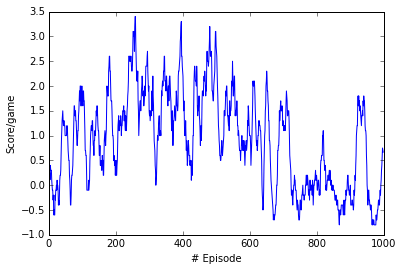

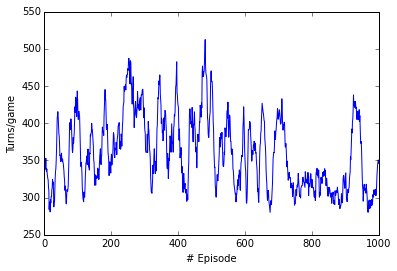

In [21]:

# Reload if score doesn't exist
if score_records is None:
    with open(path_scores,'rb') as f:
        score_records = pickle.load(f) 

def moving_avg(arr):
  mm = []
  wnd = 10
  for i in range(len(arr)):
    a = int(i - np.ceil(wnd/2))
    a = 0 if a < 0 else a
    b = int(i+np.ceil(wnd/2))
    v = arr[a:b]
    if len(v)>0:
      mm.append(np.mean(v))
  return mm

plt.figure(1)
plt.xlabel('# Episode')
plt.ylabel('Score/game')
plt.plot(moving_avg(score_records))

plt.figure(2)
plt.xlabel('# Episode')
plt.ylabel('Turns/game')
plt.plot(moving_avg(turn_records))
plt.show()